# 7. Retrieve temporal metadata from SAbDab

## Setup

In [47]:
import os
import pickle
import re
import sys; sys.path.append('../..')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set_theme()
from matplotlib.patches import Rectangle

import bin.params as p
import bin.utils as u

In [92]:
DATASET = 'test' # DO NOT FORGET TO CHANGE IF NECESSARY

# july2024
FASTA_ALIGNED_CLEANED_DIR_PATH = f'{p.DATA_DIR}/csv/fasta_aligned_cleanedJuly2024'
STRUCTURE_UPLOADED_PER_YEAR_PNG_PATH = f'{p.DATA_DIR}/png/structureUploadedPerYearJuly2024.png'
TEMPORAL_SPLIT_CUMULATIVE_WITH_SETS = f'{p.DATA_DIR}/png/temporal_splitJuly2024.png'
METADATA_DIR_PATH = f'{p.DATA_DIR}/csv/metadataJuly2024'

# old
FASTA_ALIGNED_CLEANED_DIR_PATH = f'{p.DATA_DIR}/csv/fasta_aligned_cleaned'
STRUCTURE_UPLOADED_PER_YEAR_PNG_PATH  = f'{p.DATA_DIR}/png/numberOfStructuresUploadedPerYear.png'
TEMPORAL_SPLIT_CUMULATIVE_WITH_SETS = f'{p.DATA_DIR}/png/temporal_split.png'
METADATA_DIR_PATH = f'{p.DATA_DIR}/csv/metadata' 

# common
TRAIN_CUM_PERCENTAGE = 70
VALID_CUM_PERCENTAGE = 83
PDB_DIR = f'{p.DATA_DIR}/pdb'

# show
(FASTA_ALIGNED_CLEANED_DIR_PATH, 
 STRUCTURE_UPLOADED_PER_YEAR_PNG_PATH, 
 TEMPORAL_SPLIT_CUMULATIVE_WITH_SETS, 
 METADATA_DIR_PATH, 
 PDB_DIR, TRAIN_CUM_PERCENTAGE, VALID_CUM_PERCENTAGE)

('../../data/csv/fasta_aligned_cleaned',
 '../../data/png/numberOfStructuresUploadedPerYear.png',
 '../../data/png/temporal_split.png',
 '../../data/csv/metadata',
 '../../data/pdb',
 70,
 83)

**Load the FASTA dataset:**

In [4]:
fasta = pd.read_csv(f'{FASTA_ALIGNED_CLEANED_DIR_PATH}/fasta_{p.FINAL_NUMBERING_SCHEME}_all.csv', index_col=0)
print('fasta.shape:', fasta.shape)

fasta.shape: (6572, 317)


**Helper functions:**

In [98]:
def get_summary_file_path(dataset):
    # temporary fix for July2024
    if dataset == 'test_new_234':
        summary_file_path = 'all_structures_2024/sabdab_summary_all.tsv'
    else:
        # get sabdab tsv file 
        summary_file_paths = [fn for fn in os.listdir(PDB_DIR) if fn.endswith('_summary.tsv')]
        assert len(summary_file_paths) == 1, f'multiple summary files?? {list(summary_file_paths)}'
        summary_file_path = summary_file_paths[0]
    
    summary_file_path_complete = f'{PDB_DIR}/{summary_file_path}'
    print('complete summary file path:', summary_file_path_complete) 
    return summary_file_path_complete

def load_metadata(dataset):
    path = get_summary_file_path(dataset)
    summaries_df = pd.read_csv(path, sep='\t')
    print(f'loaded {dataset} | shape: {summaries_df.shape} | columns: {list(summaries_df.columns)}')
    return summaries_df

def generate_short_metadata_df(summaries_df, interesting_columns = []):
    date_uploaded_df = summaries_df[ summaries_df['pdb'].isin(fasta_keys) ].drop_duplicates(subset=['pdb', 'date'])[interesting_columns]
    date_uploaded_df.index = date_uploaded_df['pdb']
    date_uploaded_df.sort_index(inplace=True)
    date_uploaded_df['date'] = date_uploaded_df['date'].astype('datetime64[ns]')
    date_uploaded_df['year'] = date_uploaded_df['date'].dt.year
    date_uploaded_df.drop(columns='pdb', errors='ignore', inplace=True)
    print(f'short metadata df | shape: {date_uploaded_df.shape} | columns: {list(date_uploaded_df.columns)}')
    return date_uploaded_df

**Load summary `tsv` file downloaded from `SAbDab`:**

In [77]:
summaries_df = load_metadata(DATASET)

complete summary file path: ../../data/pdb/20220601_0621156_summary.tsv
loaded test | shape: (7580, 30) | columns: ['pdb', 'Hchain', 'Lchain', 'model', 'antigen_chain', 'antigen_type', 'antigen_het_name', 'antigen_name', 'short_header', 'date', 'compound', 'organism', 'heavy_species', 'light_species', 'antigen_species', 'authors', 'resolution', 'method', 'r_free', 'r_factor', 'scfv', 'engineered', 'heavy_subclass', 'light_subclass', 'light_ctype', 'affinity', 'delta_g', 'affinity_method', 'temperature', 'pmid']


In [78]:
summaries_df = pd.read_csv(summary_file_path_complete, sep='\t')
summaries_df.head(n=2)

,pdb,Hchain,Lchain,model,antigen_chain,antigen_type,antigen_het_name,antigen_name,short_header,date,...,scfv,engineered,heavy_subclass,light_subclass,light_ctype,affinity,delta_g,affinity_method,temperature,pmid
0,1mhp,H,L,0,A,protein,NaN,"integrin alpha 1, (residues 169-360)",IMMUNE SYSTEM,08/20/02,...,False,True,IGHV3,IGKV1D,Kappa,None,None,None,None,None
1,1mhp,X,Y,0,B,protein,NaN,"integrin alpha 1, (residues 169-360)",IMMUNE SYSTEM,08/20/02,...,False,True,IGHV3,IGKV1D,Kappa,None,None,None,None,None


---

## Temporal data processing and visualization

**Extract only `pdb structure code` and `date` from the summary dataframe, remove duplicates and alter the index:**

In [80]:
fasta_keys = fasta.index.map(lambda k: k.lower()[:4])
interesting_columns = ['pdb', 'resolution', 'method', 'r_factor', 'date']
print('fasta keys length:', len(fasta_keys), '| examples:', list(fasta_keys[:5]))

fasta keys length: 6572 | examples: ['12e8', '12e8', '15c8', '15c8', '1a0q']


In [81]:
date_uploaded_df = generate_short_metadata_df(summaries_df, interesting_columns)
date_uploaded_df.head(n=2)

short metadata df | shape: (3286, 5) | columns: ['resolution', 'method', 'r_factor', 'date', 'year']


,resolution,method,r_factor,date,year
pdb,,,,,
12e8,1.9,X-RAY DIFFRACTION,0.221,1998-03-14,1998
15c8,2.5,X-RAY DIFFRACTION,0.190,1998-03-18,1998


In [24]:
date_uploaded_df.groupby('method').count()

,resolution,r_factor,date,year
method,,,,
ELECTRON MICROSCOPY,88,0,88,88
X-RAY DIFFRACTION,3198,3198,3198,3198


In [26]:
dud = date_uploaded_df
dud.groupby(['method', 'year'])['resolution'].mean()

method               year
ELECTRON MICROSCOPY  2009    2.750000
                     2017    2.500000
                     2018    2.800000
                     2019    2.840000
                     2020    2.814286
                     2021    2.757857
                     2022    2.836875
X-RAY DIFFRACTION    1984    2.700000
                     1988    3.000000
                     1989    2.387500
                     1990    2.500000
                     1991    2.375000
                     1992    2.560526
                     1993    2.398571
                     1994    2.716667
                     1995    2.515625
                     1996    2.301667
                     1997    2.367647
                     1998    2.251778
                     1999    2.423659
                     2000    2.361163
                     2001    2.319250
                     2002    2.093800
                     2003    2.142500
                     2004    2.308036
                     200

Text(0.5, 1.0, 'train+val dataset: mean resolution per year')

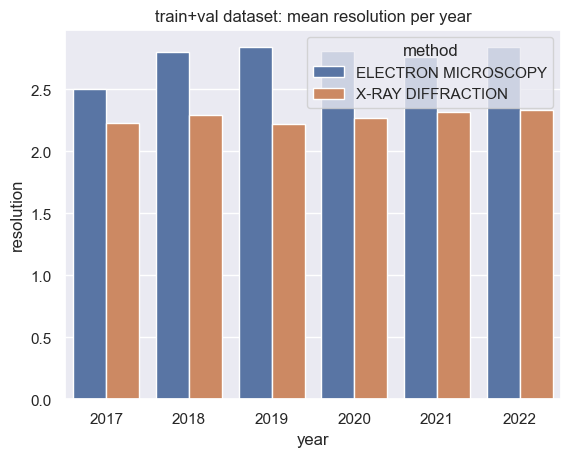

In [83]:
res_by_method_year_df = dud[dud['year'] >= 2017].groupby(['method', 'year'])['resolution'].mean().reset_index().round(2)
#res_by_method_year_df.plot.bar(x='year', y='resolution', color='method')
#res_by_method_year_df
r_plot = sns.barplot(data=res_by_method_year_df, x='year', y='resolution', hue='method')
r_plot.set_title('train+val dataset: mean resolution per year')
#res_by_method_year_df

**Check if we have summaries for all the structures:**

In [84]:
print(fasta.shape[0] / 2, date_uploaded_df.shape[0])
# FASTA df size = 2*date_uploaded_df size
# in FASTA, every structure has 2 lines (1 for each chain). In data uploaded, 1 line per structure
assert fasta.shape[0] / 2 == date_uploaded_df.shape[0]

3286.0 3286


**Group by year (we will use that in visualizations):**

In [85]:
group_by_year_df = date_uploaded_df.groupby([date_uploaded_df['date'].dt.year]).count()[['date']]
group_by_year_df.columns = ['structures_number']
group_by_year_df.index.name = 'year'
group_by_year_df.tail()

,structures_number
year,
2018,216
2019,230
2020,201
2021,309
2022,133


**Show number of uploaded structures per year barplot:**

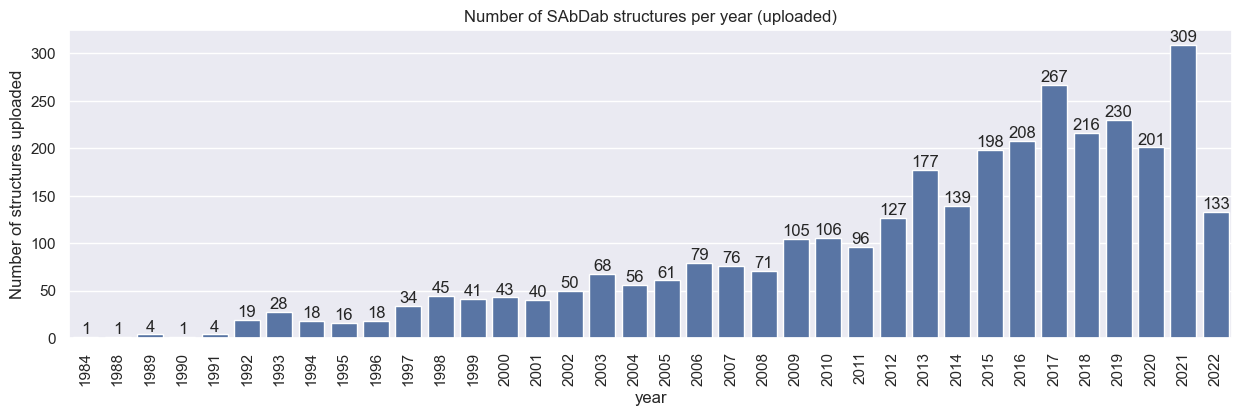

In [86]:
sns.set(rc={'figure.figsize':(15, 4)})
by_year_plot = sns.barplot(data=group_by_year_df, 
                           x=group_by_year_df.index, 
                           y='structures_number')
by_year_plot.set(title='Number of SAbDab structures per year (uploaded)', ylabel='Number of structures uploaded')
for item in by_year_plot.get_xticklabels(): item.set_rotation(90)
for i in by_year_plot.containers: by_year_plot.bar_label(i,) # display numerical values at the top of bars
by_year_plot.figure.savefig(STRUCTURE_UPLOADED_PER_YEAR_PNG_PATH)

**Cumulative percentage of structure uploads per year:**

In [87]:
data_length = group_by_year_df.sum()
uploads_cumperc_df = (group_by_year_df / data_length * 100).cumsum().round(2)
uploads_cumperc_df.columns = ['uploads_cum_percentage']
uploads_cumperc_df.tail()

,uploads_cum_percentage
year,
2018,73.43
2019,80.43
2020,86.55
2021,95.95
2022,100.00


**Show temporal split distribution (train/val/test) barplot:**

saving to: ../../data/png/temporal_split.png


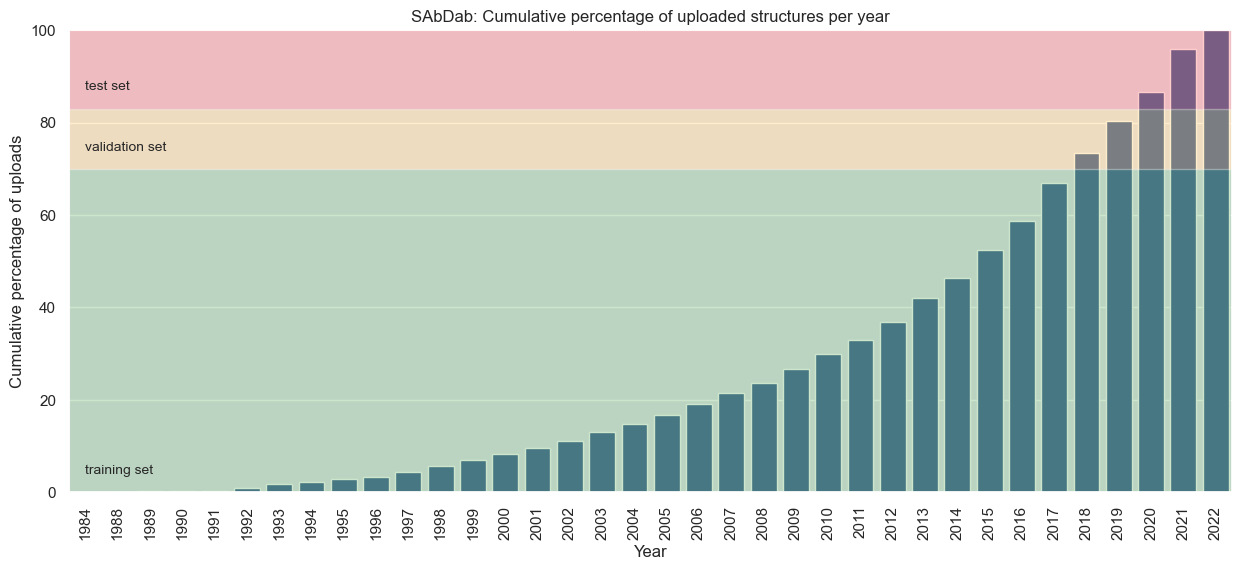

In [97]:
ALPHA = 0.2
FONTSIZE = 10
TEXT_BOTTOM_MARGIN = 4

# draw plot
sns.set(rc={'figure.figsize':(15, 6)})
year_cumperc_plot = sns.barplot(data=uploads_cumperc_df, 
                           x=uploads_cumperc_df.index, 
                           y='uploads_cum_percentage')
year_cumperc_plot.set_ylabel('Cumulative percentage of uploads')
year_cumperc_plot.set_xlabel('Year')
year_cumperc_plot.set(title='SAbDab: Cumulative percentage of uploaded structures per year')
for item in year_cumperc_plot.get_xticklabels(): item.set_rotation(90)

# draw dataset areas (rectangles)
colors = ['green', 'orange', 'red']
texts = ['training set', 'validation set', 'test set']
y_bottom_left = [0, TRAIN_CUM_PERCENTAGE, VALID_CUM_PERCENTAGE]
y_size = [TRAIN_CUM_PERCENTAGE, VALID_CUM_PERCENTAGE-TRAIN_CUM_PERCENTAGE, 105-VALID_CUM_PERCENTAGE]
currentAxis = plt.gca()
for i in range(3):
    currentAxis.add_patch(Rectangle((-0.5, y_bottom_left[i]), 
                                    100, y_size[i], facecolor=colors[i], alpha=ALPHA))
    currentAxis.text(0, y_bottom_left[i] + TEXT_BOTTOM_MARGIN, texts[i], fontsize=FONTSIZE)

#plt.xlim(0, np.max(fpr) + 0.05)
plt.ylim(0, 100)

print('saving to:', TEMPORAL_SPLIT_CUMULATIVE_WITH_SETS)
year_cumperc_plot.figure.savefig(TEMPORAL_SPLIT_CUMULATIVE_WITH_SETS)

---

## Add summary-file metadata to `metadata` dataset

**Firstly, transform `date_uploaded_df` to have the same index as `metadata`, `fasta` or `sasa` dataframes have:**

- duplicate each row
- the first of the newly made duplicates will have `:L` appended to the index key
- the second will have `:H` appended to the index key

In [93]:
# 1. generate :L copies
date_uploaded_df_l = date_uploaded_df.copy(deep=True)
new_index_l = [code.upper() + ':L' for code in date_uploaded_df.index if code.upper() + ':L' in fasta.index]
date_uploaded_df_l.index = new_index_l

# 2. generate :H copies
date_uploaded_df_h = date_uploaded_df.copy(deep=True)
new_index_h = [code.upper() + ':H' for code in date_uploaded_df.index if code.upper() + ':H' in fasta.index]
date_uploaded_df_h.index = new_index_h

# merge them
date_uploaded_new_df = pd.concat([date_uploaded_df_l, date_uploaded_df_h])
date_uploaded_new_df.sort_index(inplace=True)

# view
date_uploaded_new_df.head()

,resolution,method,r_factor,date
7DF1:H,2.806,X-RAY DIFFRACTION,0.217,2022-12-07
7DF1:L,2.806,X-RAY DIFFRACTION,0.217,2022-12-07
7E9O:H,0,ELECTRON MICROSCOPY,NaN,2022-03-09
7E9O:L,0,ELECTRON MICROSCOPY,NaN,2022-03-09
7FGJ:H,1.89,X-RAY DIFFRACTION,0.196,2022-07-27


**Add `year` and `dataset` columns.**

**`dataset` column value will be one of `train`, `val`, `test` and will be determined based on `year` column.**

In [96]:
date_uploaded_new_df['year'] = date_uploaded_new_df['date'].dt.year

def trainvaltest_divide(v):
    if v in range(1984, 2018):
        return 'train'
    elif v in range(2018, 2020):
        return 'val'
    else:
        return 'test'

if DATASET == 'test_new_234':
    date_uploaded_new_df['dataset'] = DATASET
else:
    date_uploaded_new_df['dataset'] = date_uploaded_new_df['year'].apply(trainvaltest_divide)
    
date_uploaded_new_df.tail(n=3)

,resolution,method,r_factor,date,year,dataset
8YX1:L,2.7,X-RAY DIFFRACTION,0.204,2024-05-08,2024,test_new_234
8YX9:H,2.8,X-RAY DIFFRACTION,0.209,2024-05-08,2024,test_new_234
8YX9:L,2.8,X-RAY DIFFRACTION,0.209,2024-05-08,2024,test_new_234


**Merge new dataframe with the `metadata` dataframe:**

In [97]:
metadata_df = pd.read_csv(f'{METADATA_DIR_PATH}/metadata_all.csv', index_col=0)
columns = interesting_columns + ['date', 'year', 'dataset'] 
metadata_df.drop(columns=columns, inplace=True, errors='ignore')

metadata_extended_df = pd.concat([metadata_df, date_uploaded_new_df], axis=1)
metadata_extended_df.to_csv(f'{METADATA_DIR_PATH}/metadata_all.csv')
metadata_extended_df.head()

,domain_no,hmm_species,chain_type,e-value,score,seqstart_index,seqend_index,identity_species,v_gene,v_identity,j_gene,j_identity,unaligned_len,resolution,method,r_factor,date,year,dataset
7DF1:H,0,human,H,2.300000e-58,187.0,0,122,NaN,NaN,0.0,NaN,0.0,123,2.806,X-RAY DIFFRACTION,0.217,2022-12-07,2022,test_new_234
7DF1:L,0,human,K,6.100000e-61,195.1,0,111,NaN,NaN,0.0,NaN,0.0,112,2.806,X-RAY DIFFRACTION,0.217,2022-12-07,2022,test_new_234
7E9O:H,0,alpaca,H,1.300000e-58,187.9,0,126,NaN,NaN,0.0,NaN,0.0,226,0,ELECTRON MICROSCOPY,NaN,2022-03-09,2022,test_new_234
7E9O:L,0,rhesus,K,8.300000e-58,185.2,0,112,NaN,NaN,0.0,NaN,0.0,218,0,ELECTRON MICROSCOPY,NaN,2022-03-09,2022,test_new_234
7FGJ:H,0,mouse,H,1.200000e-55,178.1,0,117,NaN,NaN,0.0,NaN,0.0,216,1.89,X-RAY DIFFRACTION,0.196,2022-07-27,2022,test_new_234


**Split `metadata_df` dataframe into `metadata_df_L` and `metadata_df_H` dataframes and export them:**

In [101]:
metadata_df = pd.read_csv(f'{METADATA_DIR_PATH}/metadata_all.csv', index_col=0)
u.select_only_chain_sequences(metadata_df, 'L').to_csv(f'{METADATA_DIR_PATH}/metadata_L.csv')
u.select_only_chain_sequences(metadata_df, 'H').to_csv(f'{METADATA_DIR_PATH}/metadata_H.csv')